# Introduction

**Survival Analysis** merupakan salah satu metode statistika untuk melakukan analisis lama waktu yang diperlukan hingga terjadinya suatu kejadian. Survival Analysis sering disebut juga sebagai **time-to-event analysis**. Melalui metode survival analysis ini, kita dapat melakukan perencanaan dengan baik atau mengambil langkah antisipasi terhadap suatu kejadian yang tidak diinginkan. Survival analysis pertama kali dikembangkan di bidang kedokteran untuk melihat pengaruh suatu treatment medis terhadap kesintasan pasien hingga meninggal dunia. Selain penerapan di bidang kedokteran, metode ini dapat diaplikasikan pada beberapa bidang atau industri berikut:

1. **Manufacturing** : Memprediksi durasi mesin tetap berjalan hingga rusak
2. **Marketing** : Memprediksi durasi berlangganan seorang konsumen hingga berhenti berlangganan
3. **Human Resources** : Memprediksi durasi seorang karyawan tetap bekerja hingga resign

## Survival Analysis vs Regression

Sejauh ini kita telah ketahui bahwa survival analysis dapat digunakan untuk memprediksi lama waktu hingga terjadinya suatu kejadian. Lalu, mengapa kita tidak menggunakan model regresi biasa yang dapat digunakan untuk memprediksi suatu nilai numerik?

Untuk menjawab hal tersebut, kita perlu memahami konsep **censored observation** yaitu observasi yang belum diketahui secara pasti apakah kapan observasi tersebut mengalami kejadian. Tipe-tipe *censored observation*:

1. **Right censored** : Observasi yang hingga batas akhir pengamatan tidak mengalami kejadian. Contoh: Seorang dokter mengamati kejadian kematian pada pasiennya yang terkena penyakit diabetes selama 12 bulan sejak didiagnosis penyakit tersebut. Jika terdapat pasien yang tidak meninggal selama 12 bulan tersebut maka observasi tersebut disebut *right censored*
2. **Left censored** : Observasi yang sudah mengalami kejadian sebelum waktu pengamatan dimulai. Contoh: Seseorang sudah terkena penyakit diabetes sebelum dokter mengamati pasien tersebut lebih lanjut.
3. **Interval censored** : Observasi yang tidak diketahui secara pasti kapan mengalami kejadian. Contoh: Seorang teknisi mesin mengamati unit-unit mesin hingga mesin tersebut rusak selama 3 bulan sekali. Misalkan terdapat mesin yang mati saat diamati pada bulan ke-9. Kita tidak ketahui secara pasti kapan mesin tersebut rusak namun yang kita ketahui adalah mesin tersebut rusak diantara bulan ke-6 dan ke-9.

Adanya *censored observation* tersebut yang membuat kita tidak dapat menggunakan model regresi biasa. Pada metode survival analysis ini, observasi *right censored* yang akan kita gunakan karena tipe observasi tersebut sering muncul.

## Konsep Matematika

Misalkan $T$ adalah peubah acak yang menyatakan waktu hingga terjadinya suatu kejadian. Maka

1. **Fungsi Kepadatan Peluang (*Probability Density Function*, PDF)** $f(t) = P(T = t)$: peluang suatu kejadian terjadi saat waktu $t$
2. **Fungsi Distribusi Kumulatif (*Cumulative Distribution Function*, CDF)** $F(t) = P(T <= t)$: peluang suatu kejadian terjadi sebelum waktu $t$. Secara matematis, CDF dapat didefinisikan sebagai berikut:
$$
F(t) = \int_{0}^{t}{f(s)} ds
$$
3. **Fungsi Distribusi Survival (*Survival Distribution Function*, SDF)** $S(t) = P(T>t)$: peluang suatu kejadian terjadi setelah waktu $t$. Secara matematis, SDF dapat didefinisikan sebagai berikut:
$$
S(t) = 1 - F(t)
$$
4. **Fungsi Hazard (*Hazard Rate Function/Force of Mortality*)** $h(t)$ : peluang bersyarat terjadinya suatu kejadian saat waktu $t$ diketahui subjek yang diamati belum mengalami kejadian saat waktu $t$. Secara matematis, fungsi hazard dapat diperoleh sebagai berikut:
$$
h(t) = - \frac{d}{dt} ln(S(t))
$$

Hubungan antara $f(t), F(t), S(t), h(t)$ dapat dilihat pada diagram berikut

**Insert diagram here**

# Import Library

In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(16,9)})

# Import Data and Preprocessing

Kita akan menggunakan [dataset mesin NASA](https://www.kaggle.com/datasets/behrad3d/nasa-cmaps) yang pada setiap barisnya berisi banyak siklus yang telah dilakukan suatu mesin. Pada setiap siklus tersebut dilakukan pengaturan terhadap tiga jenis pengaturan operasional kemudian dicatat berdasarkan 22 pengukuran yang berbeda.

In [258]:
# Define columns name
column1 = ["machine_name", "cycle", "operational_setting_1", "operational_setting_2", "operational_setting_3"]
column2 = [f'sensor_measurement_{i:02}' for i in range(1,22)]
columns = column1 + column2

In [259]:
# Read data
turbofan_df = pd.read_csv("dataset/train_FD002.txt", header = None, sep = "\s+", names = columns)
turbofan_df.head()

,machine_name,cycle,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_01,sensor_measurement_02,sensor_measurement_03,sensor_measurement_04,sensor_measurement_05,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


## Create Censored Data

Jika kita lihat pada data di atas, data yang kita miliki bukanlah data yang memiliki observasi *right censored*. Untuk mendapatkan observasi tersebut, kita lakukan tahapan berikut:

1. Memilih siklus maksimum hingga mesin rusak pada setiap mesin
2. Mengasumsikan batas akhir waktu pengamatan

In [260]:
# Select maximum cycle
max_cycle = turbofan_df.groupby(by = "machine_name")['cycle'].transform(max)
turbofan_df = turbofan_df[turbofan_df["cycle"] == max_cycle].set_index('machine_name')
turbofan_df.head()

,cycle,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_01,sensor_measurement_02,sensor_measurement_03,sensor_measurement_04,sensor_measurement_05,sensor_measurement_06,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
machine_name,,,,,,,,,,,,,,,,,,,,,
1,149,42.0017,0.8414,100.0,445.00,550.49,1366.01,1149.81,3.91,5.71,...,129.55,2387.40,8066.19,9.4765,0.02,332,2212,100.0,10.45,6.2285
2,269,42.0047,0.8411,100.0,445.00,550.11,1368.75,1146.65,3.91,5.72,...,129.76,2388.42,8110.26,9.4315,0.02,334,2212,100.0,10.56,6.2615
3,206,42.0073,0.8400,100.0,445.00,550.80,1356.97,1144.89,3.91,5.72,...,130.02,2387.87,8082.25,9.4962,0.02,333,2212,100.0,10.46,6.3349
4,235,0.0030,0.0007,100.0,518.67,643.68,1605.86,1428.21,14.62,21.61,...,520.25,2388.17,8215.14,8.5784,0.03,397,2388,100.0,38.47,22.9717
5,154,42.0049,0.8408,100.0,445.00,550.53,1364.82,1146.87,3.91,5.72,...,130.05,2389.19,8151.36,9.4339,0.02,333,2212,100.0,10.74,6.3906


Selanjutnya, kita buat lollipop plot untuk memperoleh distribusi siklus maksimum pada setiap mesin

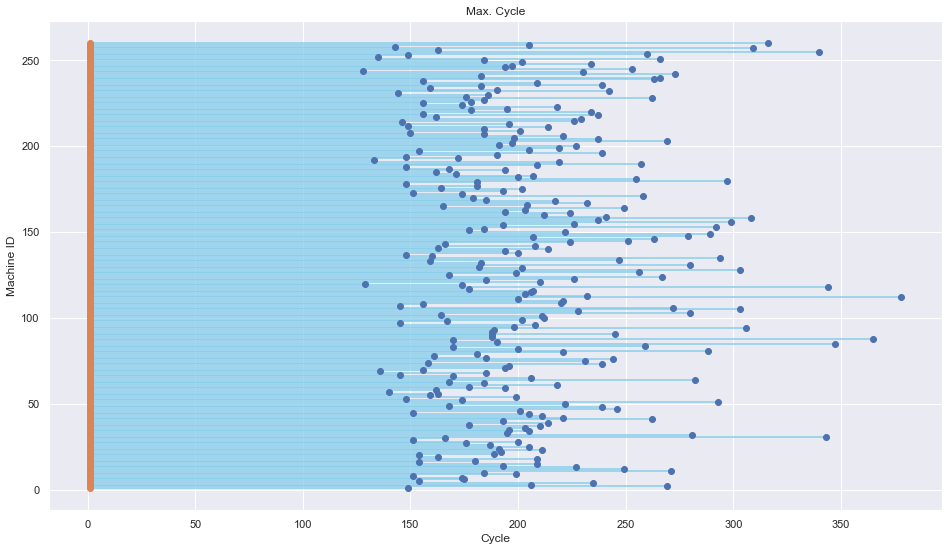

In [261]:
# Lollipop plot for each machine name
plt.hlines(y=turbofan_df.index, xmin=1, xmax=turbofan_df['cycle'], color='skyblue')
plt.plot(turbofan_df['cycle'], turbofan_df.index, "o")
plt.plot([1 for i in range(len(turbofan_df))], turbofan_df.index, "o")

# Add titles and axis names
plt.title("Max. Cycle")
plt.xlabel('Cycle')
plt.ylabel('Machine ID')

# Show the plot
plt.show()

> Kita asumsikan bahwa batas akhir waktu pengamatan adalah 220 siklus sehingga ketika mesin masih aktif setelah 220 siklus maka mesin tersebut akan dianggap right censored

In [262]:
# Create status column
turbofan_df['status'] = turbofan_df['cycle'].apply(lambda x: False if x > 200 else True)

In [263]:
turbofan_df.head(5)

,cycle,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_01,sensor_measurement_02,sensor_measurement_03,sensor_measurement_04,sensor_measurement_05,sensor_measurement_06,...,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,status
machine_name,,,,,,,,,,,,,,,,,,,,,
1,149,42.0017,0.8414,100.0,445.00,550.49,1366.01,1149.81,3.91,5.71,...,2387.40,8066.19,9.4765,0.02,332,2212,100.0,10.45,6.2285,True
2,269,42.0047,0.8411,100.0,445.00,550.11,1368.75,1146.65,3.91,5.72,...,2388.42,8110.26,9.4315,0.02,334,2212,100.0,10.56,6.2615,False
3,206,42.0073,0.8400,100.0,445.00,550.80,1356.97,1144.89,3.91,5.72,...,2387.87,8082.25,9.4962,0.02,333,2212,100.0,10.46,6.3349,False
4,235,0.0030,0.0007,100.0,518.67,643.68,1605.86,1428.21,14.62,21.61,...,2388.17,8215.14,8.5784,0.03,397,2388,100.0,38.47,22.9717,False
5,154,42.0049,0.8408,100.0,445.00,550.53,1364.82,1146.87,3.91,5.72,...,2389.19,8151.36,9.4339,0.02,333,2212,100.0,10.74,6.3906,True


> Status mesin `True` menunjukkan bahwa mesin tersebut rusak dalam rentang waktu pengamatan sedangkan `False` menunjukkan mesin belum mengalami kejadian kerusakan selama rentang waktu pengamatan

In [264]:
# Distribution of each status
turbofan_df['status'].value_counts()

True     136
False    124
Name: status, dtype: int64

# Exploratory Data Analysis

Langkah selanjutnya adalah melakukan *feature selection* yaitu pemilihan kolom/variabel yang dapat dimasukkan ke dalam model

## Check Uniqueness

Pertama kita akan memeriksa banyak nilai unik pada setiap kolom lalu kolom yang memiliki nilai unik yang sedikit akan diganti dengan tipe data kategori.

In [265]:
turbofan_df.nunique()

cycle                    133
operational_setting_1    165
operational_setting_2     62
operational_setting_3      2
sensor_measurement_01      6
sensor_measurement_02    188
sensor_measurement_03    257
sensor_measurement_04    251
sensor_measurement_05      6
sensor_measurement_06      8
sensor_measurement_07    209
sensor_measurement_08    177
sensor_measurement_09    259
sensor_measurement_10      8
sensor_measurement_11    123
sensor_measurement_12    198
sensor_measurement_13    152
sensor_measurement_14    258
sensor_measurement_15    247
sensor_measurement_16      2
sensor_measurement_17     27
sensor_measurement_18      6
sensor_measurement_19      2
sensor_measurement_20    135
sensor_measurement_21    253
status                     2
dtype: int64

> Kolom yang dapat diganti ke tipe kategori: `operational_setting_3`, `sensor_measurement_16`

In [266]:
# Change to category
category_columns = ['operational_setting_3', 'sensor_measurement_16']

turbofan_df[category_columns] = turbofan_df[category_columns].astype('category')
turbofan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 1 to 260
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   cycle                  260 non-null    int64   
 1   operational_setting_1  260 non-null    float64 
 2   operational_setting_2  260 non-null    float64 
 3   operational_setting_3  260 non-null    category
 4   sensor_measurement_01  260 non-null    float64 
 5   sensor_measurement_02  260 non-null    float64 
 6   sensor_measurement_03  260 non-null    float64 
 7   sensor_measurement_04  260 non-null    float64 
 8   sensor_measurement_05  260 non-null    float64 
 9   sensor_measurement_06  260 non-null    float64 
 10  sensor_measurement_07  260 non-null    float64 
 11  sensor_measurement_08  260 non-null    float64 
 12  sensor_measurement_09  260 non-null    float64 
 13  sensor_measurement_10  260 non-null    float64 
 14  sensor_measurement_11  260 non-null    flo

## Correlation Heatmap

Kita dapat memeriksa korelasi antar kolom calon prediktor untuk melihat apakah terdapat korelasi yang tinggi antar prediktor. Variabel yang memiliki korelasi yang tinggi dengan variabel lainnya perlu dipilih salah satu saja untuk menghindari terjadinya multikolinearitas

<AxesSubplot:>

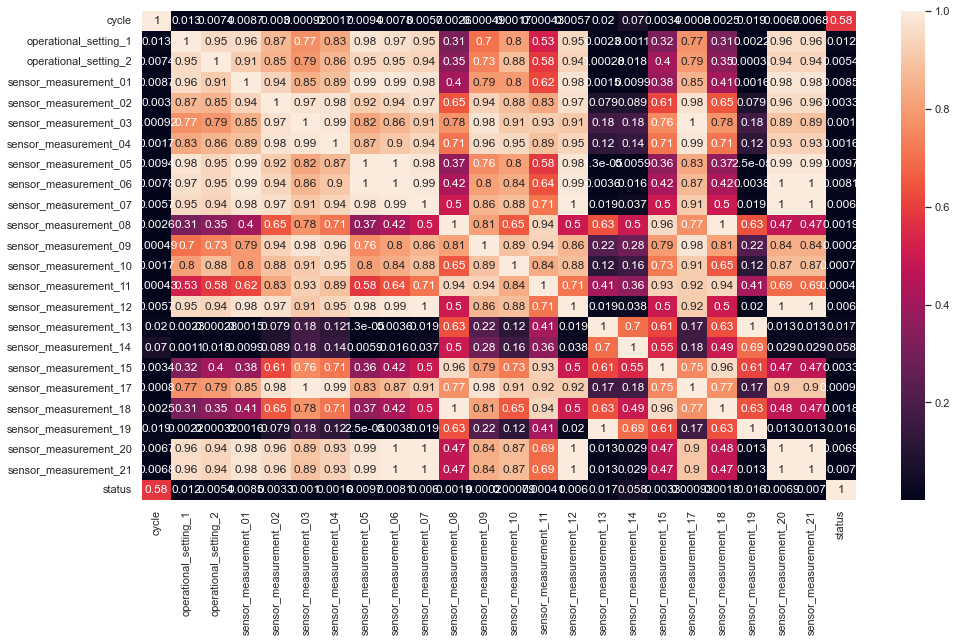

In [267]:
sns.heatmap(turbofan_df.corr()**2, annot = True,)

> Pada plot di atas, korelasi antar variabel terlihat cukup tinggi. Pada kasus ini kita akan coba pilih terlebih dahulu kolom `sensor_measurement_04`,`sensor_measurement_08`, `sensor_measurement_11`, `sensor_measurement_14`

<AxesSubplot:>

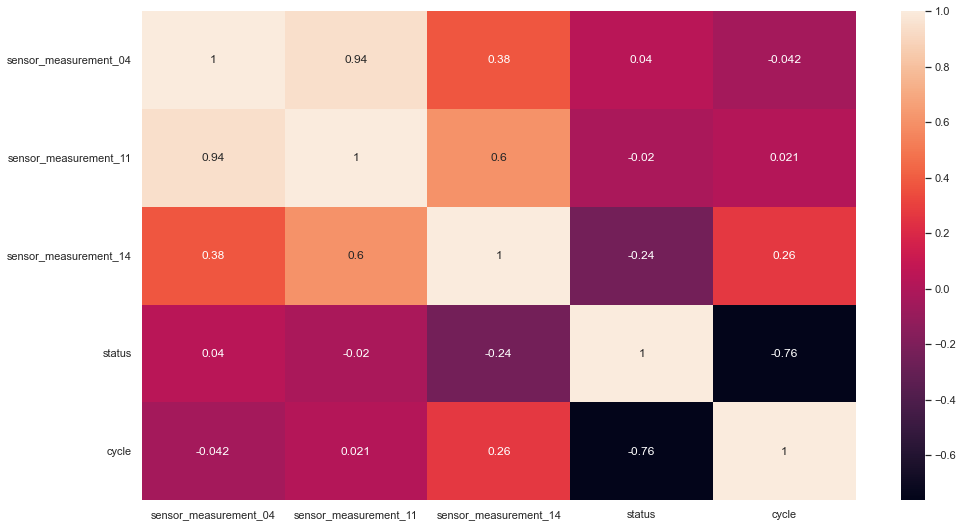

In [268]:
selected_columns = ['sensor_measurement_04','sensor_measurement_11','sensor_measurement_14']
cleaned_data = turbofan_df.loc[:, selected_columns + category_columns + ['status', 'cycle']]
sns.heatmap(cleaned_data.corr(), annot = True)

# Data Preparation for Modeling

Langkah selanjutnya adalah menyiapkan data untuk melakukan pemodelan. Hal yang perlu diperhatikan adalah:

1. Untuk kolom dengan tipe kategori perlu dilakukan One Hot Encoding
2. Untuk data target, perlu dituliskan dalam bentuk array dengan setiap elemennya adalah sebuah tuple yang terdiri dari status mesin (True/False) dan waktu/siklusnya

In [269]:
# One Hot Encoding for Categorical Variable
from sksurv.preprocessing import OneHotEncoder

data_x = OneHotEncoder().fit_transform(cleaned_data.iloc[:, :-2])
data_x.head()

,sensor_measurement_04,sensor_measurement_11,sensor_measurement_14,operational_setting_3=100.0,sensor_measurement_16=0.03
machine_name,,,,,
1,1149.81,42.77,8066.19,1.0,0.0
2,1146.65,42.64,8110.26,1.0,0.0
3,1144.89,42.85,8082.25,1.0,0.0
4,1428.21,48.25,8215.14,1.0,1.0
5,1146.87,42.67,8151.36,1.0,0.0


In [270]:
# Preprocessing for target variable

data_y = list(cleaned_data.loc[:, ["status", "cycle"]].itertuples(index = None, name = None))
data_y = np.array(data_y, dtype=[('status', bool), ('cycle', float)])
data_y[:5]

array([( True, 149.), (False, 269.), (False, 206.), (False, 235.),
       ( True, 154.)], dtype=[('status', '?'), ('cycle', '<f8')])

# Kaplan Meier Estimator

Dari data yang telah kita miliki di atas maka kita dapat membangun fungsi survival **Kaplan Meier Estimator**. Kaplan Meier Estimator dibangun dengan menghitung peluang observasi yang survive (tidak mengalami kejadian) pada setiap waktu. Secara matematis, Kaplan Meier Estimator dapat dituliskan sebagai berikut:
$$
S(t) = \prod_{j=1}^{t} \frac{n_j - d_j}{n_j} 
$$
dengan $n_j$ adalah banyaknya subject saat waktu $j$ dan $d_j$ adalah banyaknya subject yang mengalami kejadian.

Sebagai ilustrasi, misalkan kita memiliki data berikut

| ID | Waktu | Event |
| --- | --- | --- |
| 1 | 6 | 1 |
| 2 | 40 | 0 |
| 3 | 21 | 1 |
| 4 | 14 | 1 |
| 5 | 40 | 0 |

Maka,
1. Untuk waktu $0 \leq t < 6$, terdapat 5 observasi dan tidak terdapat observasi yang mengalami event. Maka
$$S(t) = \frac{5-0}{5} = 1 $$
2. Untuk waktu $6 \leq t < 14$ terdapat 5 observasi dan satu diantaranya mengalami event. Maka
$$S(t) = 1 * \frac{5-1}{5} = \frac{4}{5} = 0.8$$
3. Untuk waktu $14 \leq t < 21$ terdapat 4 observasi dan satu diantaranya mengalami event. Maka
$$S(t) = 1 * \frac{4}{5} * \frac{4-1}{4} = \frac{3}{5} = 0.6$$
4. Untuk waktu $21 \leq t < 40$ terdapat 3 observasi dan satu diantaranya mengalami event. Maka
$$S(t) = 1 * \frac{4}{5} * \frac{4-1}{4} * \frac{3-1}{3} = \frac{2}{5} = 0.4$$
5. Untuk waktu $t \geq 40$ tersisa 2 observasi dan tidak terdapat observasi yang mengalami event. Maka
$$S(t) = 1 * \frac{4}{5} * \frac{4-1}{4} * \frac{3-1}{3} * \frac{2-0}{2} = 0.4$$

Berikut adalah cara untuk membangun fungsi survival menggunakan Kaplan Meier Estimator menggunakan package `sksurv`

Text(0.5, 0, 'time $t$')

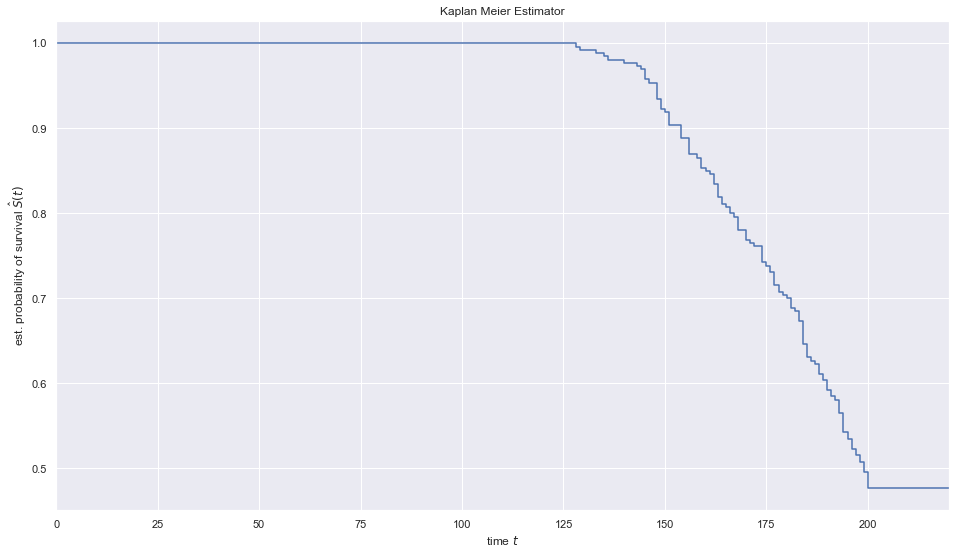

In [271]:
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(data_y["status"], data_y["cycle"])
time, survival_prob = np.append(0, time), np.append(1, survival_prob)

# Plotting
plt.step(time, survival_prob, where = "post")
plt.xlim(left = 0, right = 220)
plt.title("Kaplan Meier Estimator")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

**Interpretasi:**

1. Hingga saat $t=125$ nilai $S(t)=1$ yang menunjukkan bahwa semua mesin tetap hidup hingga siklus ke-125
2. Saat $t=175$ nilai $S(t)$ berada di sekitar 0.75 menunjukkan bahwa setelah terdapat sekitar 75% mesin tetap hidup hingga siklus ke 175
3. Peluang mesin tetap hidup menjadi 50% setelah siklus ke-190

## Compare Survival Time for Each Category in Every Categorical Columns

Kita telah mempelajari bagaimana membangun fungsi survival menggunakan Kaplan Meier Estimator. Terkadang kita ingin melakukan perbandingan apakah adanya perbedaan kategori/perlakuan akan memengaruhi kesintasan subjek yang kita amati.

Misalkan, pada data `cleaned_data` kita memiliki dua buah kolom yang memiliki tipe kategori yaitu `operational_setting_3` dan `sensor_measurement_16`. Mari kita periksa banyaknya nilai unik pada kedua kolom tersebut

In this section, we will compare the distribution of survival time for each category in every categorical columns. From the distribution we hope that we can determined if there is a difference distribution for each category or not.

In [272]:
os3_unique = list(cleaned_data['operational_setting_3'].unique())
sm16_unique = list(cleaned_data['sensor_measurement_16'].unique())
print(f'Nilai unik operational_setting_3: {os3_unique}')
print(f'Nilai unik sensor_measurement_16: {sm16_unique}')

Nilai unik operational_setting_3: [100.0, 60.0]
Nilai unik sensor_measurement_16: [0.02, 0.03]


Sekarang kita akan melakukan perbandingan distribusi fungsi survival antara nilai 100 dan 60 pada kolom `operational_setting_3`

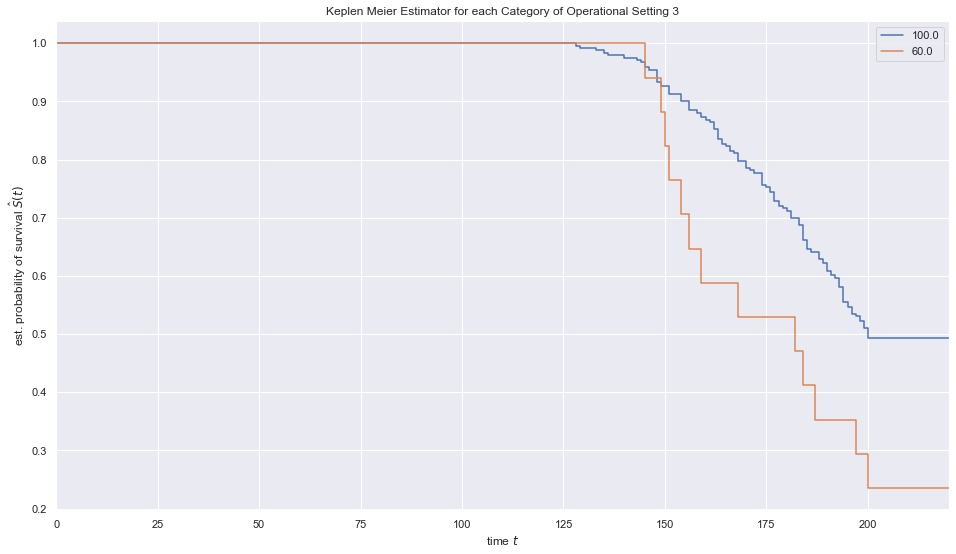

In [273]:
for category in cleaned_data['operational_setting_3'].unique():
    category_df = cleaned_data[cleaned_data['operational_setting_3'] == category]
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(category_df['status'],
                                                                     category_df['cycle'])
    time_treatment , survival_prob_treatment = np.append(0, time_treatment), np.append(1, survival_prob_treatment)
    plt.step(time_treatment, survival_prob_treatment, where = "post", label = category)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title(f"Keplen Meier Estimator for each Category of Operational Setting 3")
plt.legend(loc="best")
plt.xlim(left = 0, right = 220)
plt.show()

> **Interpretasi**: Berdasarkan visualisasi di atas, dapat kita lihat bahwa nilai `operational_setting_3 = 100` cenderung memiliki nilai fungsi survival yang lebih tinggi dibandingkan `operational_setting_3 = 60` yang menunjukkan bahwa `operational_setting_3 = 100` lebih tahan lama dibandingkan `operational_setting_3 = 60`

Hal yang sama kita lakukan untuk kolom `sensor_measurement_16`

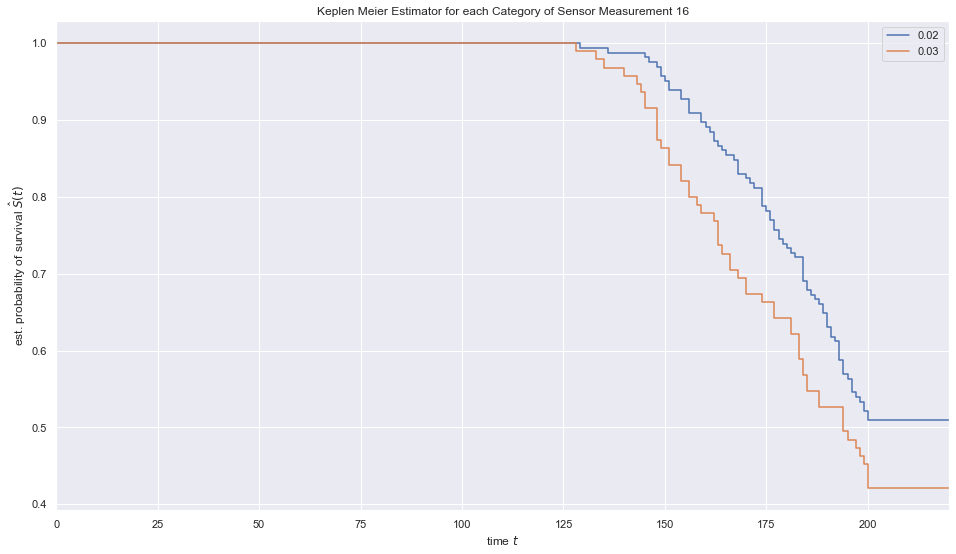

In [274]:
for category in cleaned_data['sensor_measurement_16'].unique():
    category_df = cleaned_data[cleaned_data['sensor_measurement_16'] == category]
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(category_df['status'],
                                                                     category_df['cycle'])
    time_treatment , survival_prob_treatment = np.append(0, time_treatment), np.append(1, survival_prob_treatment)
    plt.step(time_treatment, survival_prob_treatment, where = "post", label = category)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title(f"Keplen Meier Estimator for each Category of Sensor Measurement 16")
plt.legend(loc="best")
plt.xlim(left = 0, right = 220)
plt.show()

> **Interpretasi**: Berdasarkan visualisasi di atas, dapat kita lihat bahwa nilai `sensor_measurement_16 = 0.02` cenderung memiliki nilai fungsi survival yang lebih tinggi dibandingkan `sensor_measurement_16 = 0.03` (walaupun tidak berbeda jauh secara signifikan) yang menunjukkan bahwa `sensor_measurement_16 = 0.02` lebih tahan lama dibandingkan `sensor_measurement_16 = 0.03`

# Log-Rank Test

Pada bagian sebelumnya, kita telah melakukan perbandingan distribusi fungsi survival melalui visualisasi. Namun terkadang kita memerlukan uji statistik lebih lanjut untuk memastikan apakah kedua distribusi tersebut dapat dikatakan sama atau berbeda secara signifikan. Untuk melakukan pengujian tersebut, kita dapat menggunakan **Log-Rank Test** dengan hipotesis

$H_{0}$ : Distribusi kedua fungsi survival sama
$H_{1}$ : Distribusi kedua fungsi survival berbeda


In [275]:
from sksurv.compare import compare_survival

p_value_list = []
for column in category_columns:
    p_value = compare_survival(data_y, turbofan_df[column])[1]
    p_value_list.append(p_value)
    
result = pd.DataFrame({'columns': category_columns, 'p-value': p_value_list}).set_index('columns')
result['conclusion'] = result['p-value'].apply(lambda x: "significant" if x < 0.05 else "not significant")
result

,p-value,conclusion
columns,,
operational_setting_3,0.009559,significant
sensor_measurement_16,0.078070,not significant


> **Kesimpulan** : Untuk kolom `operational_setting_3` terdapat perbedaan distribusi fungsi survival pada setiap kategorinya sedangkan untuk kolom `sensor_measurement_16` tidak terdapat perbedaan yang signifikan

Karena tidak terdapat perbedaan yang signifikan pada setiap kategorinya, maka kita dapat menghapus variabel `sensor_measurement_16` pada data kita

In [276]:
data_x = data_x[data_x.columns[~data_x.columns.isin(["sensor_measurement_16=0.03"])]]

# Cox Propotional Hazard

Model **Cox Propotional Hazard (CoxPH)** dapat digunakan untuk melakukan pemodelan terdahap Data Survival. Secara matematis, model ini dapat dituliskan sebagai berikut:
$$
h(t) = h_{0}(t) e^{\beta_{1}x_{1} + \beta_{2}x_{2} + ... + \beta_{n}x_{n}}
$$

Model CoxPH ini adalah model semiparametric yang akan memprediksi nilai hazard rate yang terdiri dari komponen:

- Non-parametrik $h_{0}(t)$ (*baseline hazard*) : Karakterisasi mengenai bagaimana fungsi hazard berubah seiring berjalannya waktu. Baseline hazard ini dapat diinterpretasikan juga sebagai intercept pada masalah regresi
- Parametrik $e^{\beta_{1}x_{1} + \beta_{2}x_{2} + ... + \beta_{n}x_{n}}$ : Karakterisasi mengenai bagaimana fungsi hazard berubah berdasarkan kondisi kovariat (variabel yang terlibat dalam model)

Untuk memperoleh fungsi survival berdasarkan model di atas, kita dapat memanfaatkan hubungan berikut:
$$
S(t) = e^{-\int{h(t)}} dt
$$

Kita dapat memanfaatkan fungsi `CoxPHSurvivalAnalysis` dari package `sksurv` untuk membangun model CoxPH. Pada kasus ini, kita gunakan parameter `alpha = 1e-4` sebagai untuk regularisasi. Dokumentasi lebih lengkap untuk penggunaan fungsi ini dapat dilihat pada [dokumentasi berikut](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.linear_model.CoxPHSurvivalAnalysis.html)

In [277]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

# Define model
estimator = CoxPHSurvivalAnalysis(verbose = 10)

# Fitting model
estimator.fit(data_x, data_y)

iter      1: update = [-0.02470019  1.18145225  0.01042852 -5.88955353]
iter      1: loss = 2.6737640940
iter      2: update = [ 0.00050559 -0.04450495  0.00163026 -0.3549446 ]
iter      2: loss = 2.6717369669
iter      3: update = [-8.28653221e-06  4.13295190e-04  5.79435411e-06 -1.69962579e-02]
iter      3: loss = 2.6717324194
iter      4: update = [ 1.28327480e-08 -6.51120386e-07 -6.46272452e-09 -7.61965419e-05]
iter      4: loss = 2.6717324193
iter      4: optimization converged


CoxPHSurvivalAnalysis(verbose=10)

Setelah melakukan fitting model, mari kita lihat koefisien dari model dengan menggunakan attribute `.coef_`

In [278]:
# Coef model
pd.Series(estimator.coef_, index = data_x.columns)

sensor_measurement_04          0.024203
sensor_measurement_11         -1.137360
sensor_measurement_14         -0.012065
operational_setting_3=100.0    6.261571
dtype: float64

**Interpretation:**

- Setiap peningkatan satu satuan pada `sensor_measurement_04` akan meningkatkan tingkat kerusakan (hazard rate) sebesar $e^{0.02} = 1.02$ dengan asumsi tidak ada perubahan pada covariate lainnya
- Setiap peningkatan satu satuan pada `sensor_measurement_11` akan mengurangi tingkat kerusakan (hazard rate) sebesar $e^{-1.27} = 0.28$ dengan asumsi tidak ada perubahan pada covariate lainnya
- Dengan menggunakan `operational_setting_3` = 100 akan meningkatkan tingkat kerusakan (hazard rate) sebesar $e^{6.46} = 639.06$ dibandingkan dengan `operational_setting_3` = 60



# Model Evaluation

Salah satu metrics yang dapat digunakan untuk mengevaluasi model survival analysis adalah **C-index**. Pada masalah survival analysis, C-index merepresentasikan seberapa mampu model dapat membedakan risiko suatu observasi. Ketika nilai C-index menuju 1 maka model memiliki kemampuan untuk membedakan observasi yang memiliki risiko tinggi dan rendah sedangkan jika nilainya menuju 0.5 maka model tidak memiliki kemampuan untuk membedakan observasi yang berisiko tinggi atau rendah.

In [279]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(data_x)
result = concordance_index_censored(turbofan_df["status"], turbofan_df["cycle"], prediction)
result[0]

0.6640009272137227

In [280]:
estimator.score(data_x, data_y)

0.6640009272137227